# Finding Related Cores

 Using a real data set.
 
 See [Cores](Cores.ipynb) for some background.

In [1]:
import sqlalchemy

import joblib

from itertools import chain, combinations, product

cfi = chain.from_iterable

from collections import OrderedDict as odict

from scipy.spatial.distance import pdist, cdist

from rdkit.Chem.MCS import FindMCS

import networkx as nx

from local_utils.rdkit_utils import FP, pairwise_sim
from local_utils.data_utils import pprint 

import core_sets

### Reload active molecules

In [2]:
mols = pd.read_pickle('test_mols.pkl')

mols.shape

(64, 2)

,mol,FP
parent_chembl_id,,
CHEMBL1926835,,"[0 0 0 ..., 0 0 0]"

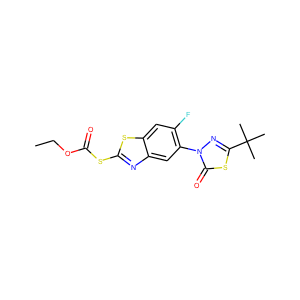

In [3]:
mols.head(1)

### Add cores

_AKA_ Murko scaffolds

In [4]:
# Add cores (i.e. Murko scaffolds)...

PandasTools.AddMurckoToFrame(mols, molCol='mol', MurckoCol='core', Generic=False)

PandasTools.AddMoleculeColumnToFrame(mols, smilesCol='core', molCol='core_mol')

mols['core_n'] = pd.Categorical.from_array(mols['core']).categories.get_indexer(mols['core'])

mols['parent_chembl_id'] = mols.index

mols.sort('core', inplace=True)

,mol,FP,core,core_mol,core_n,parent_chembl_id
parent_chembl_id,,,,,,
CHEMBL2252326,,"[0 0 0 ..., 0 0 0]",O=C1C2=C(CCCC2)CN1c1cccc(OCc2ccccc2)c1,,0,CHEMBL2252326

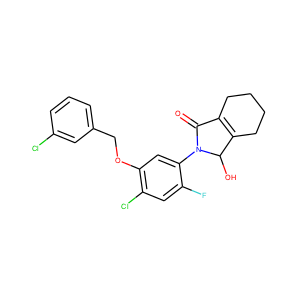
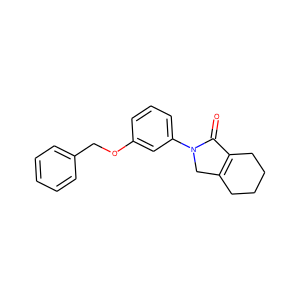

In [5]:
mols.head(1)

In [6]:
# Group molecules by core...

def f(group):
    
    compounds = list(group['parent_chembl_id'])
        
    if len(compounds) > 1:
        
        sims = 1.0 - pdist(list(mols.loc[compounds]['FP'].apply(lambda x: x.fp)), metric='jaccard')
        
        mean, maxm = sims.mean(), sims.max()
        
    else:
        
        mean, maxm = 0.0, 0.0
    
    # return pd.Series({'compounds': compounds, 'n_compounds': len(compounds), 'intra_mean': mean, 'intra_max': maxm})
    
    return pd.Series([compounds, len(compounds), mean, maxm], index=['compounds', 'n_compounds', 'intra_mean', 'intra_max'])

cores = mols.groupby('core').apply(f)

cores.sort('n_compounds', ascending=False, inplace=True)

cores['percent'] = (100*cores['n_compounds'].cumsum()/len(mols)).apply(lambda x: round(x, 2)) # % of compounds accounted for by core

cores['mol'] = [Chem.MolFromSmiles(x) for x in cores.index] # Add molecule (for inspection)

# cores.drop('compounds', axis=1, inplace=True)

cores.shape

(8, 6)

,compounds,n_compounds,intra_mean,intra_max,percent,mol
core,,,,,,
O=c1ocnn1-c1ccc2scnc2c1,"[CHEMBL1926962, CHEMBL1926968, CHEMBL1926858, CHEMBL1926974, CHEMBL1926970, CHEMBL1926971, CHEMBL1926969, CHEMBL2230219, CHEMBL2230215, CHEMBL2230214, CHEMBL2230216, CHEMBL2230212, CHEMBL2230206, CHEMBL2230213, CHEMBL2230207, CHEMBL2230208, CHEMBL2230209, CHEMBL2230211, CHEMBL1926967, CHEMBL1926960, CHEMBL1926963, CHEMBL1926961, CHEMBL1926863, CHEMBL1926857, CHEMBL1926964, CHEMBL1926862, CHEMBL1926966, CHEMBL1926860, CHEMBL1926861, CHEMBL1926859, CHEMBL1926972, CHEMBL1926965, CHEMBL1926973]",33,0.642938,0.906250,51.56,
O=c1scnn1-c1ccc2scnc2c1,"[CHEMBL1926844, CHEMBL1926842, CHEMBL1926843, CHEMBL1926838, CHEMBL1926846, CHEMBL1926839, CHEMBL1926836, CHEMBL1926845, CHEMBL1926835, CHEMBL1926841, CHEMBL1926849, CHEMBL1926840, CHEMBL1926837]",13,0.687846,0.903226,71.88,
O=C1C2=C(CCCC2)CN1c1ccccc1,"[CHEMBL2252323, CHEMBL2252335, CHEMBL2252319, CHEMBL2252321, CHEMBL2252320, CHEMBL2252328, CHEMBL2252322, CHEMBL2252332, CHEMBL2252347, CHEMBL2252327]",10,0.546862,0.836735,87.50,
O=C1C2=C(CCCC2)CN1c1cccc(OCc2ccccc2)c1,"[CHEMBL2252326, CHEMBL2252331, CHEMBL2252325]",3,0.775292,0.862069,92.19,
O=C1C2CCCCC2C(=O)N1c1ccccc1,"[CHEMBL2252337, CHEMBL2252339]",2,0.622642,0.622642,95.31,
O=c1[nH]cnn1-c1ccccc1,[CHEMBL1884669],1,0.000000,0.000000,96.88,
O=c1ocnn1-c1ccccc1,[CHEMBL1080648],1,0.000000,0.000000,98.44,
c1ccc(Oc2ccccc2)cc1,[CHEMBL222440],1,0.000000,0.000000,100.00,

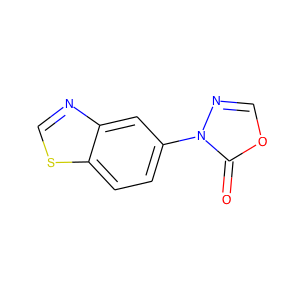
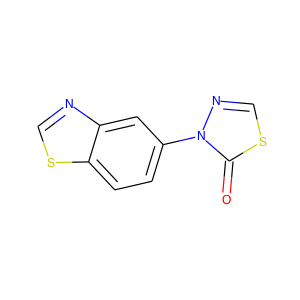
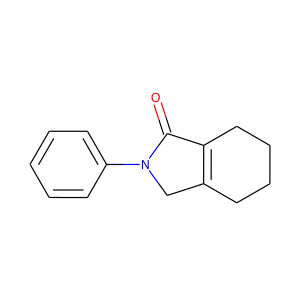
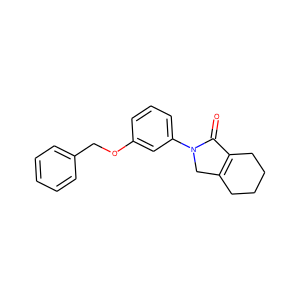
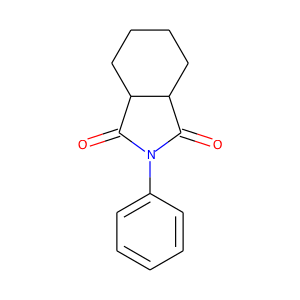
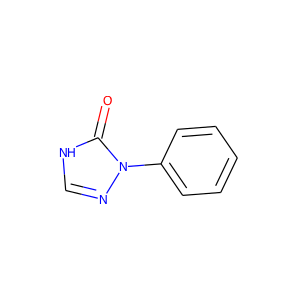
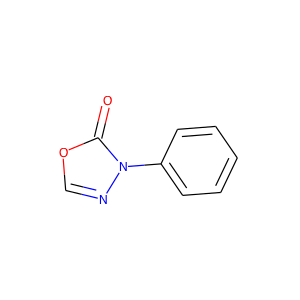
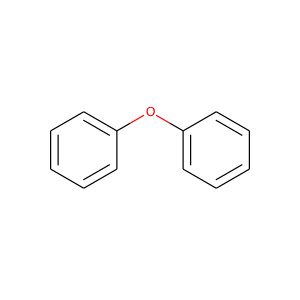

In [7]:
cores

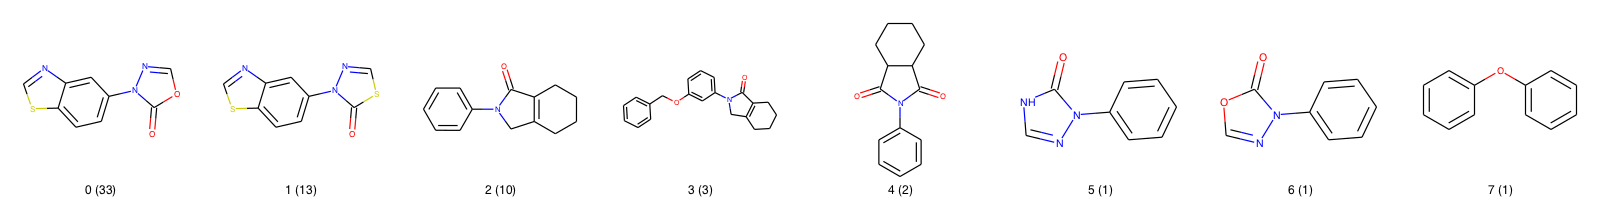

In [8]:
Draw.MolsToGridImage(cores['mol'], legends=["{} ({})".format(i, x) for i, x in enumerate(cores['n_compounds'])], molsPerRow=8)

### Examine pairs of cores

In [9]:
# Get similarities and 'dfference scores' for pairs of cores...

def f(i, j):
    
    mol_0, mol_1 = cores['mol'][i], cores['mol'][j]

    sim = pairwise_sim(mol_0, mol_1)
       
    diff_1 = core_sets.get_diff_1(mol_0, mol_1)
    
    diff_2 = core_sets.get_diff_2(mol_0, mol_1)
    
    return pd.Series([i, j, mol_0, mol_1, round(sim, 2), diff_1, diff_2], index=['i', 'j', 'mol_0', 'mol_1', 'sim', 'diff_1', 'diff_2'])
    
core_pairs = pd.DataFrame(f(i, j) for i, j in combinations(range(len(cores['mol'])), 2))

core_pairs.shape

(28, 7)

,i,j,mol_0,mol_1,sim,diff_1,diff_2
0,0,1,,,0.63,1,0

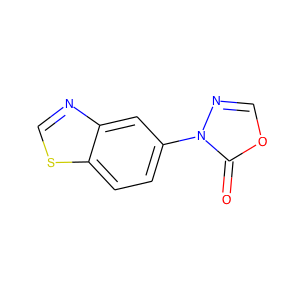
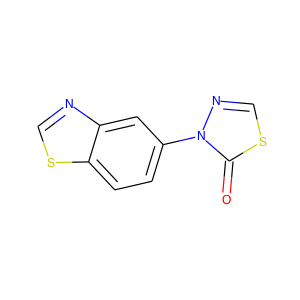

In [10]:
core_pairs.head(1)

In [11]:
# Get matrices of FPs for the sets of molecules corresponding to cores...

def f(x):
    
    fp = mols.loc[x]['FP'].apply(lambda x: x.fp)

    n = len(fp)
    
    X = np.zeros((n, FP.N_BITS), FP.DTYPE)

    for i in range(n): X[i] = fp[i]
    
    return np.matrix(X)

matrices = cores['compounds'].apply(f).tolist()

In [12]:
# Add inter-core similarities based on the molecules corresponding to the cores...

def f(row):
    
    i, j = row
    
    sims = 1.0 - cdist(matrices[i], matrices[j], 'jaccard')
    
    (n_compounds_0, intra_mean_0, intra_max_0), (n_compounds_1, intra_mean_1, intra_max_1) = cores.iloc[[i, j]][['n_compounds', 'intra_mean', 'intra_max']].to_records(index=False)
        
    return pd.Series([n_compounds_0, intra_mean_0, intra_max_0, n_compounds_1, intra_mean_1, intra_max_1, sims.mean(), sims.max()],
                     index=['n_cpds_0', 'intra_mean_0', 'intra_max_0', 'n_cpds_1', 'intra_mean_1', 'intra_max_1', 'inter_mean', 'inter_max'])

core_pairs = pd.merge(core_pairs, core_pairs[['i', 'j']].apply(f, axis=1), left_index=True, right_index=True, sort=False)

,i,j,mol_0,mol_1,sim,diff_1,diff_2,n_cpds_0,intra_mean_0,intra_max_0,n_cpds_1,intra_mean_1,intra_max_1,inter_mean,inter_max
0,0,1,,,0.63,1,0,33,0.64,0.91,13,0.69,0.90,0.47,0.74

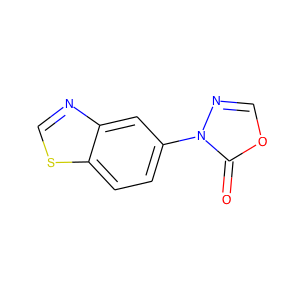
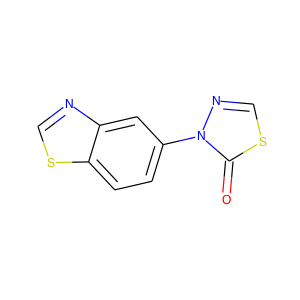

In [13]:
# Display the pairs of cores...

for col in ['diff_1', 'diff_2', 'n_cpds_0', 'n_cpds_1']:  core_pairs[col] = core_pairs[col].astype(int)
    
pd.options.display.float_format = '{:.2f}'.format

core_pairs.head(1)

### Examine pairs of molecules for a core

_i.e._ All combinations of the molecules belonging to a core.

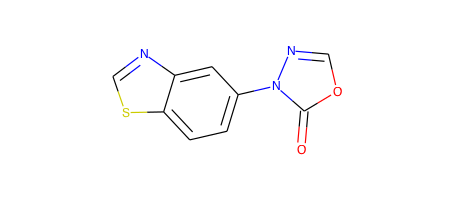

In [14]:
core_n = 0

cores['mol'][core_n]

In [15]:
def f(cid_0, cid_1):
    
    record_0, record_1 = mols.loc[cid_0], mols.loc[cid_1]
    
    sim = (1.0 - pdist([record_0['FP'].fp, record_1['FP'].fp], 'jaccard'))[0]
    
    return pd.Series([cid_0, record_0['mol'], cid_1, record_1['mol'], sim], index=['cid_0', 'mol_0', 'cid_1', 'mol_1', 'sim'])

cids = cores.iloc[core_n]['compounds']

mol_pairs = pd.DataFrame(f(x, y) for x, y in combinations(cids, 2)).sort('sim', ascending=False)

mol_pairs.shape

(528, 5)

,cid_0,mol_0,cid_1,mol_1,sim
121,CHEMBL1926974,,CHEMBL1926973,,0.91

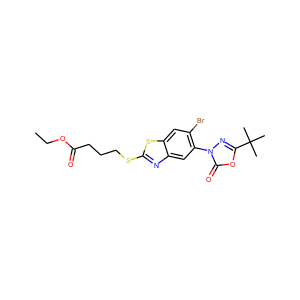
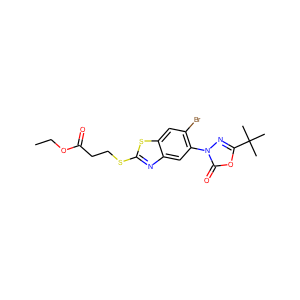

In [16]:
mol_pairs.head(1)

### Examine pairs of structures for a pair of cores

All combinations of the molecules belonging to a pair of cores (_i.e._ the Cartesion product).

In [17]:
# Utility to align a set of molecules to their MCS.

def mcs_align(mols):
    
    if len(mols) > 1:
        
        mols = [Chem.Mol(x) for x in mols] # Use copies of input mols
        
        # Get MCS and corresponding pattern...

        mcs = FindMCS(mols, atomCompare="elements", bondCompare="bondtypes", ringMatchesRingOnly=False, completeRingsOnly=False)

        pattern = Chem.MolFromSmarts(mcs.smarts)

        AllChem.Compute2DCoords(pattern)
        
        # Fix 2D coords of pattern such that they correspond to those for the first molecule...

        template = Chem.Mol(mols[0])

        AllChem.Compute2DCoords(template)

        conf0 = template.GetConformer(0)

        conf1 = pattern.GetConformer(0)

        match = template.GetSubstructMatch(pattern)

        for i, j in zip(match, range(len(match))): conf1.SetAtomPosition(j, conf0.GetAtomPosition(i))
            
        # Align mols using fixed-up pattern,,,

        for x in mols: AllChem.GenerateDepictionMatching2DStructure(x, pattern)
        
        return {'mols': mols, 'numAtoms': mcs.numAtoms, 'numBonds': mcs.numBonds}
    
    else:
        
        return {'mols': mols, 'numAtoms': 0, 'numBonds': 0}

In [18]:
# Core pair index...

core_pair_n = 13 # 5 # 14

# Core indices...

i, j = core_pairs.iloc[core_pair_n][['i', 'j']]

if len(cores['mol'][i].GetAtoms()) > len(cores['mol'][j].GetAtoms()): i, j = j, i # Swap so smaller mol is alays first

mcs = mcs_align([cores['mol'][i], cores['mol'][j]])

core_0, core_1 = mcs['mols']
    
len(core_0.GetAtoms()), len(core_1.GetAtoms()), mcs['numAtoms'], mcs['numBonds']

(16, 24, 16, 18)

In [19]:
# Draw.MolsToGridImage([cores['mol'][i], cores['mol'][j]], molsPerRow=8)

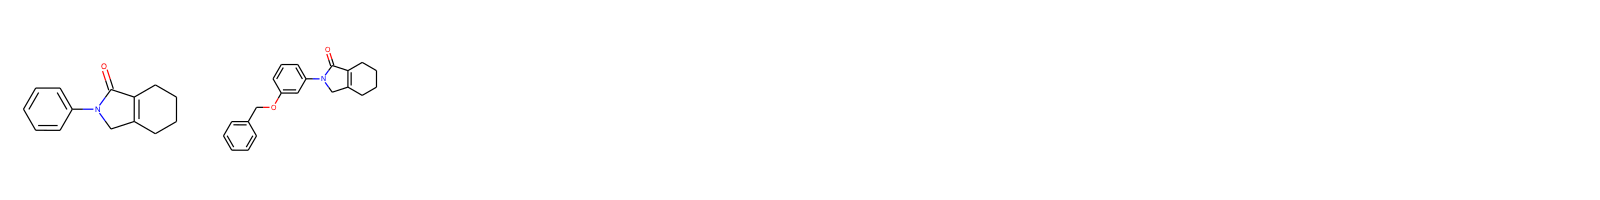

In [20]:
# Show the (aligned) cores...

Draw.MolsToGridImage([core_0, core_1], molsPerRow=8)

In [21]:
# Get list of corresponding molecule ChEMBL IDs for each of the two cores...

cids_i, cids_j = cores['compounds'][i], cores['compounds'][j]

# Calculate similarity for all pairs of molecules (Cartesian product of molecules from pair of cores)...

def f(cid_0, cid_1):
    
    row_0, row_1 = mols.loc[cid_0], mols.loc[cid_1]

    # FP Similarity...
        
    fp_0, fp_1 = row_0['FP'].fp, row_1['FP'].fp
    
    sim = (1.0 - pdist([fp_0, fp_1], 'jaccard'))[0]
    
    # MCS...

    mcs = mcs_align([row_0['mol'], row_1['mol']])
                     
    mol_0, mol_1 = mcs['mols']
    
    n_atoms_0, n_atoms_1, n_atoms_mcs, n_bonds_mcs = len(mol_0.GetAtoms()), len(mol_1.GetAtoms()), mcs['numAtoms'], mcs['numBonds']
    
    mcs_diff = (n_atoms_0 + n_atoms_1)/2 - n_atoms_mcs
        
    # Done...
    
    return pd.Series([cid_0, mol_0, cid_1, mol_1, sim, n_atoms_0, n_atoms_1, n_atoms_mcs, n_bonds_mcs, mcs_diff],
                     index=['cid_0', 'mol_0', 'cid_1', 'mol_1', 'sim', 'n_atoms_0', 'n_atoms_1', 'n_atoms_mcs', 'n_bonds_mcs', 'mcs_diff'])

mol_pairs = pd.DataFrame(f(x, y) for x, y in product(cids_i, cids_j)).sort('sim', ascending=False).reset_index()

mol_pairs.shape

(30, 11)

,index,cid_0,mol_0,cid_1,mol_1,sim,n_atoms_0,n_atoms_1,n_atoms_mcs,n_bonds_mcs,mcs_diff
0,22,CHEMBL2252332,,CHEMBL2252331,,0.69,22,29,22,24,3.50

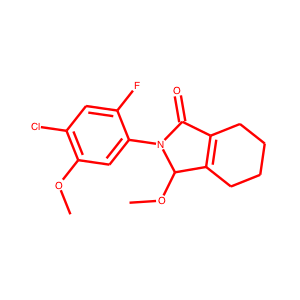
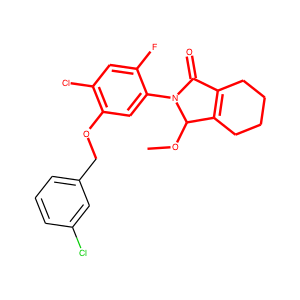

In [22]:
mol_pairs.head(1)

### Reload activity data

In [23]:
data = pd.read_pickle('test_data.pkl')

data.shape

(26, 33)

In [24]:
HTML(data.head(1).to_html())

,assay_chembl_id,assay,endpoint,relation,value,pvalue,units,activity_comment,compound_name_in_source,version_molregno,version_chembl_id,version_smiles,parent_molregno,parent_chembl_id,parent_smiles,parent_amw,target_chembl_id,tid,target,species,source,doc_id,reference_chembl_id,reference,pubmed_id,assay_test_type,assay_tissue,assay_cell_type,relationship_type,data_validity_comment,potential_duplicate,is_active,is_pubchem
0,CHEMBL3066844,Inhibition of Homo sapiens (human) protoporphyrinogen oxidase,Ki,=,95.00,7.02,nM,None,C6,1476251,CHEMBL2252322,CCCOc1cc(N2CC3=C(CCCC3)C2=O)c(F)cc1Cl,1476251,CHEMBL2252322,CCCOc1cc(N2CC3=C(CCCC3)C2=O)c(F)cc1Cl,323.79,CHEMBL1926488,104383,Protoporphyrinogen oxidase,Homo sapiens,Scientific Literature,69694,CHEMBL3046018,"Bioorg. Med. Chem. 2010, v. 18, p. 7948",20934343,None,None,None,D,None,None,yes,no


In [25]:
means = data[['parent_chembl_id', 'pvalue']].groupby('parent_chembl_id').mean().to_dict()['pvalue']

for n in [0, 1]: mol_pairs["act_{}".format(n)] = [round(means[x], 2) for x in mol_pairs["cid_{}".format(n)]]

mol_pairs['act_diff'] = mol_pairs.apply(lambda x: abs(x['act_0'] - x['act_1']), axis=1)

,index,cid_0,mol_0,cid_1,mol_1,sim,n_atoms_0,n_atoms_1,n_atoms_mcs,n_bonds_mcs,mcs_diff,act_0,act_1,act_diff
10,16,CHEMBL2252328,,CHEMBL2252331,,0.51,23,29,22,24,4.00,5.99,5.99,0.00
22,26,CHEMBL2252347,,CHEMBL2252325,,0.38,22,28,21,23,4.00,6.16,6.11,0.05
24,8,CHEMBL2252319,,CHEMBL2252325,,0.36,21,28,20,22,4.50,6.17,6.11,0.06
25,6,CHEMBL2252319,,CHEMBL2252326,,0.36,21,28,20,22,4.50,6.17,6.28,0.11
2,17,CHEMBL2252328,,CHEMBL2252325,,0.66,23,28,22,24,3.50,5.99,6.11,0.12
21,24,CHEMBL2252347,,CHEMBL2252326,,0.38,22,28,21,23,4.00,6.16,6.28,0.12
23,25,CHEMBL2252347,,CHEMBL2252331,,0.38,22,29,21,23,4.50,6.16,5.99,0.17
26,7,CHEMBL2252319,,CHEMBL2252331,,0.35,21,29,20,22,5.00,6.17,5.99,0.18
28,9,CHEMBL2252321,,CHEMBL2252326,,0.35,22,28,20,22,5.00,6.52,6.28,0.24
1,15,CHEMBL2252328,,CHEMBL2252326,,0.66,23,28,22,24,3.50,5.99,6.28,0.29

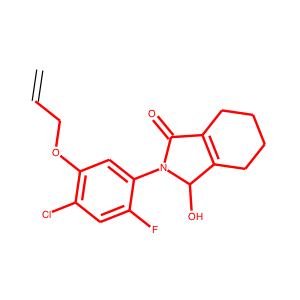
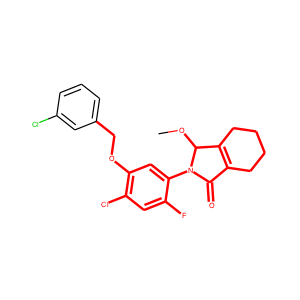
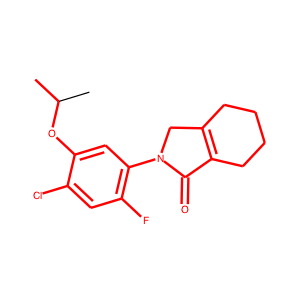
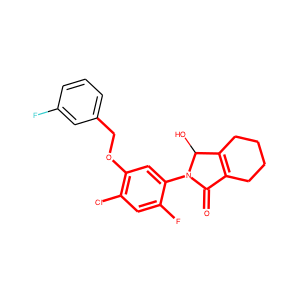
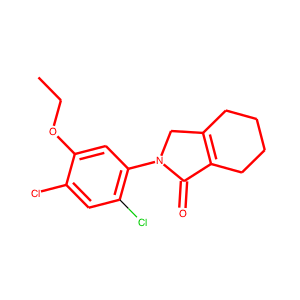
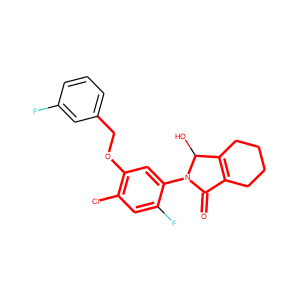
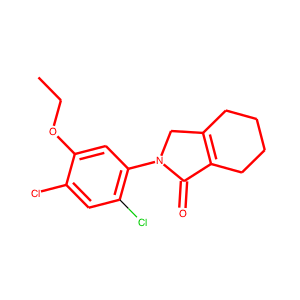
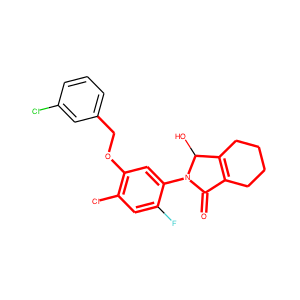
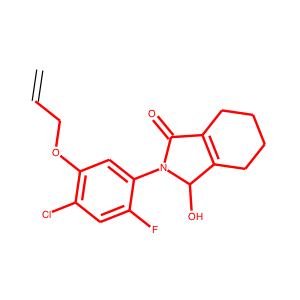
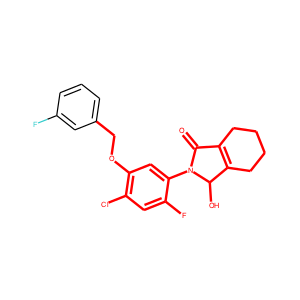
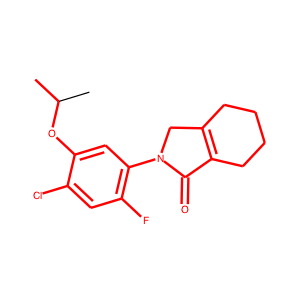
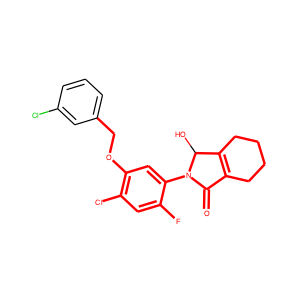
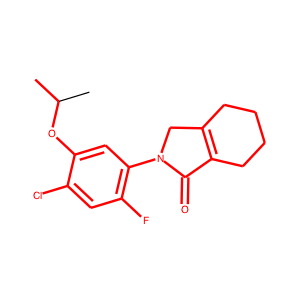
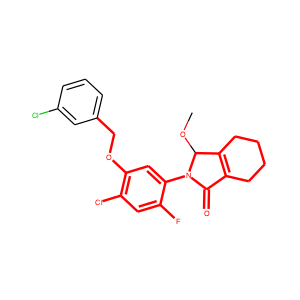
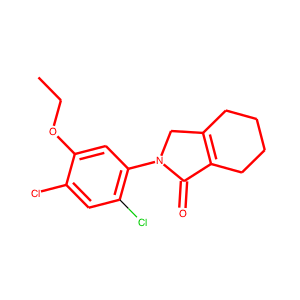
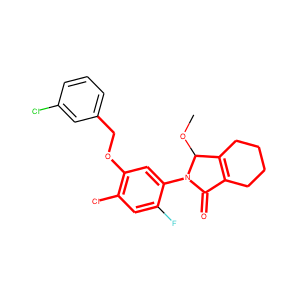
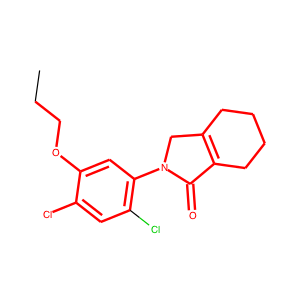
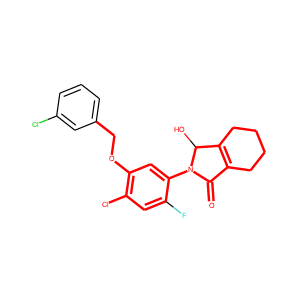
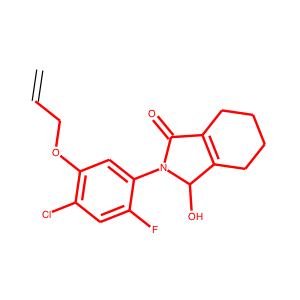
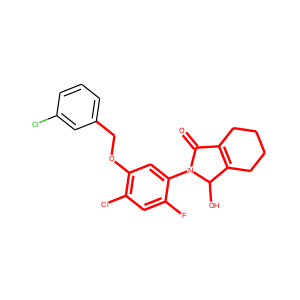
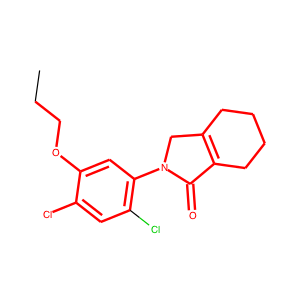
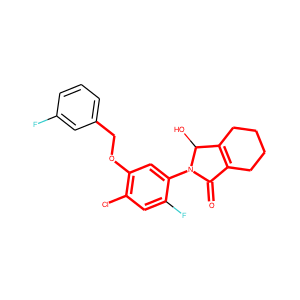
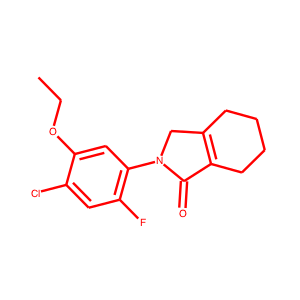
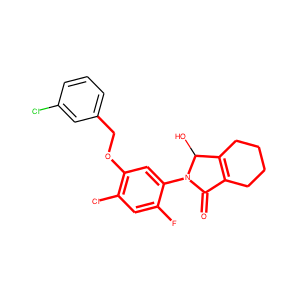
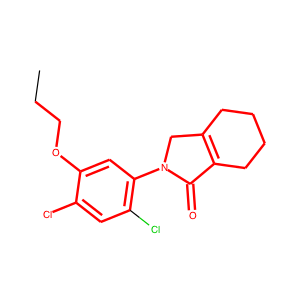
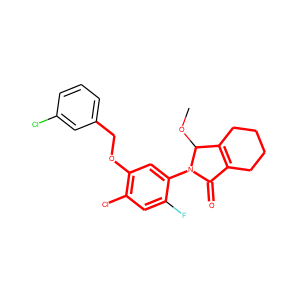
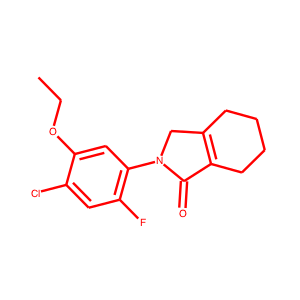
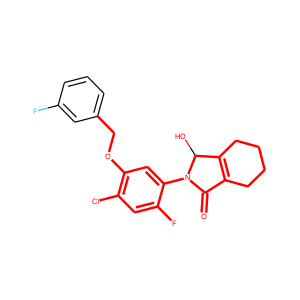
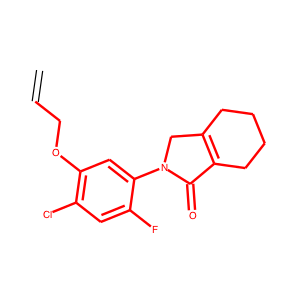
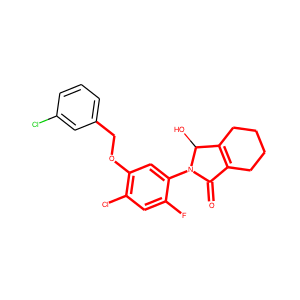
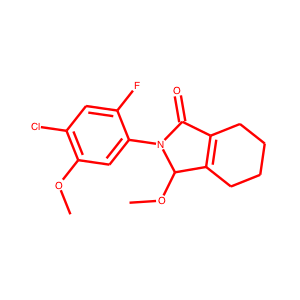
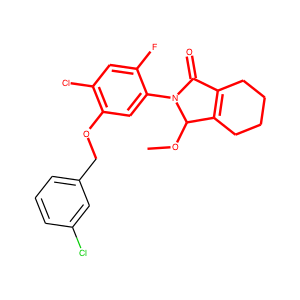
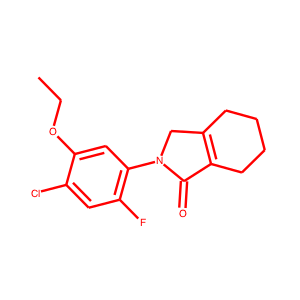
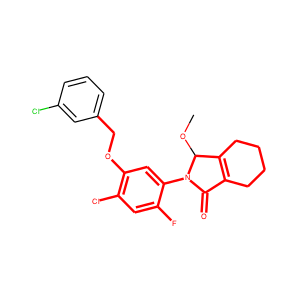
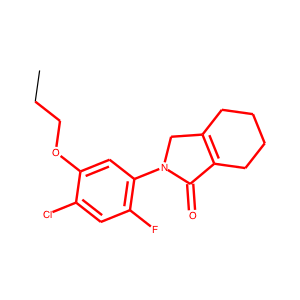
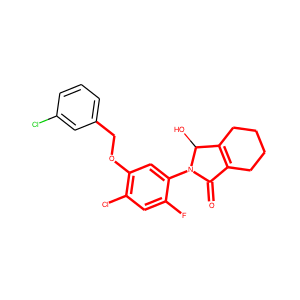
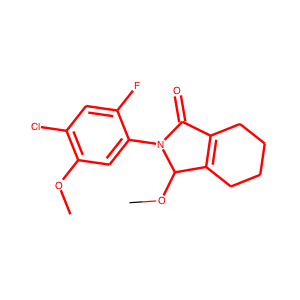
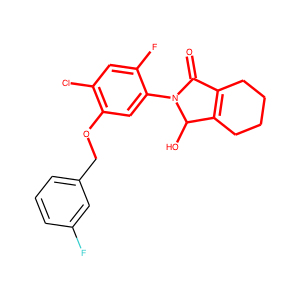
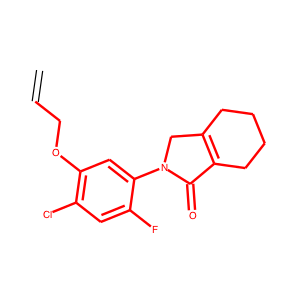
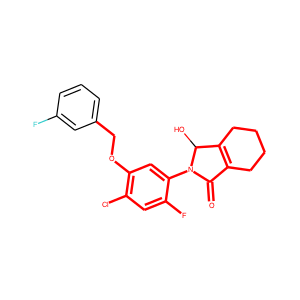
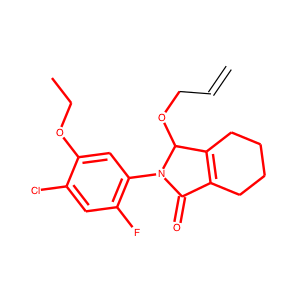
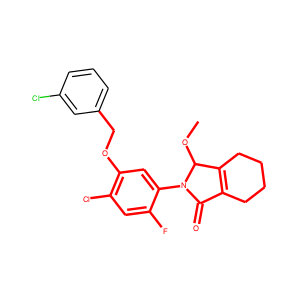
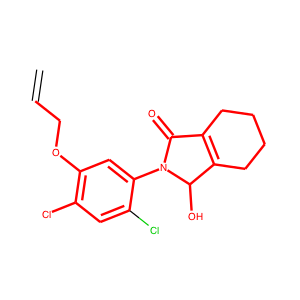
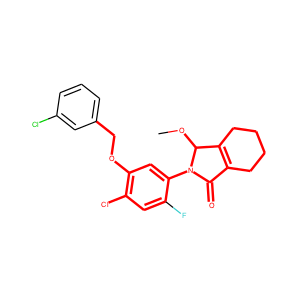
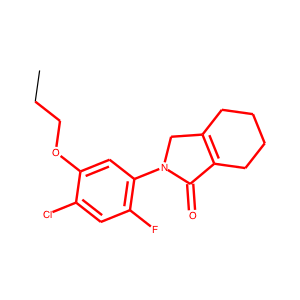
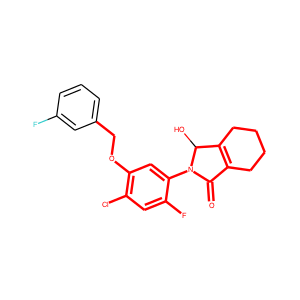
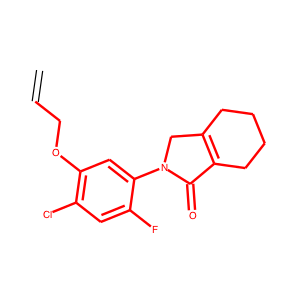
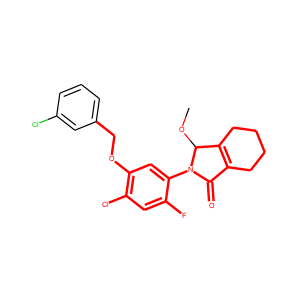
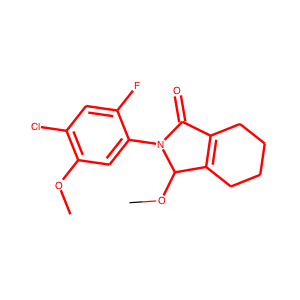
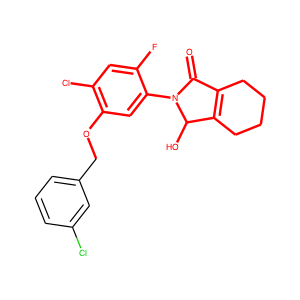
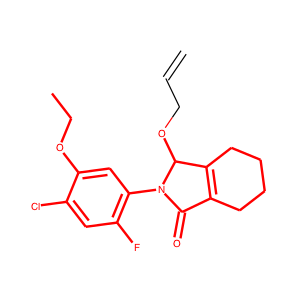
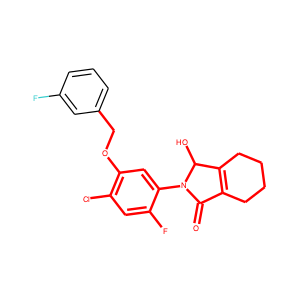
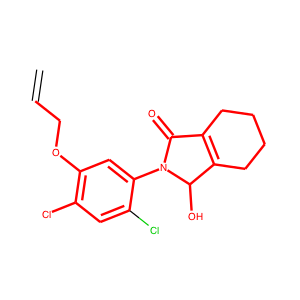
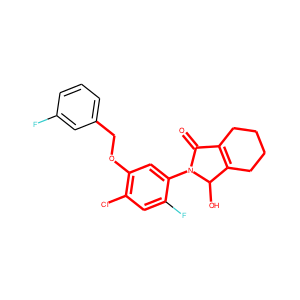
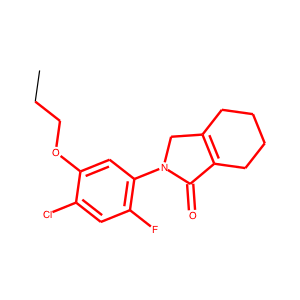
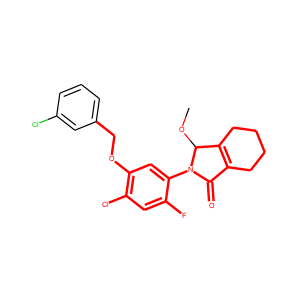
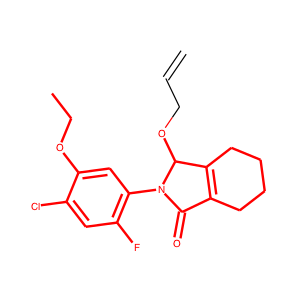
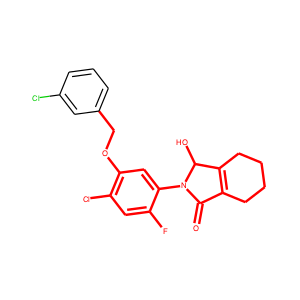
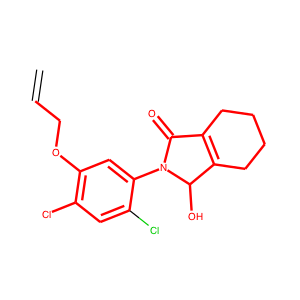
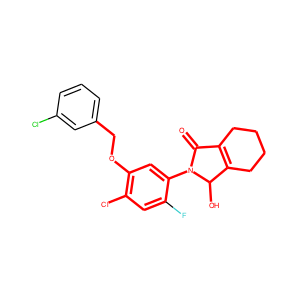

In [26]:
mol_pairs.sort('act_diff')

### Relationship between activity difference and similarity/diffrerence of molecules

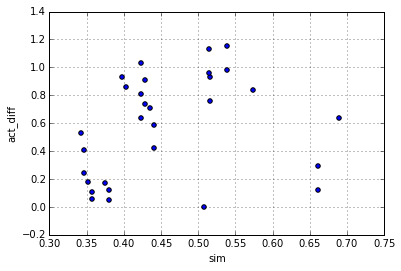

In [27]:
mol_pairs.plot(x='sim', y='act_diff', kind='scatter')

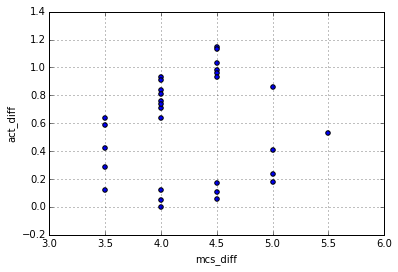

In [28]:
mol_pairs.plot(x='mcs_diff', y='act_diff', kind='scatter')

### Group related cores

Group related cores using a graph.

In [29]:
dist_threshold = 3

# Substructures...

check_substruct = False

substruct_dist = 2

In [30]:
graph = nx.Graph()

edge_labels = {}

for i, j, dist in core_pairs[['i', 'j', 'diff_2']].to_records(index=False):
    
    graph.add_node(i)
    graph.add_node(j)
    
    ##########

    if check_substruct:

        core_0, core_1 = cores['mol'][i], cores['mol'][j]

        mcs_n = mcs_align([core_0, core_1])['numAtoms']

        if mcs_n == len(core_0.GetAtoms()) or mcs_n == len(core_1.GetAtoms()):

            dist = substruct_dist
    
    ##########

    if dist > dist_threshold: continue
        
    graph.add_edge(i, j, weight=(dist_threshold - dist)*10, dist=dist)

# Get label dicts...

edge_labels = {edge: graph.get_edge_data(*edge)['dist'] for edge in graph.edges()}

node_labels = {node: node for node in graph.nodes()}

/usr/local/lib/python2.7/site-packages/matplotlib-1.4.x-py2.7-macosx-10.8-x86_64.egg/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/site-packages/matplotlib-1.4.x-py2.7-macosx-10.8-x86_64.egg/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


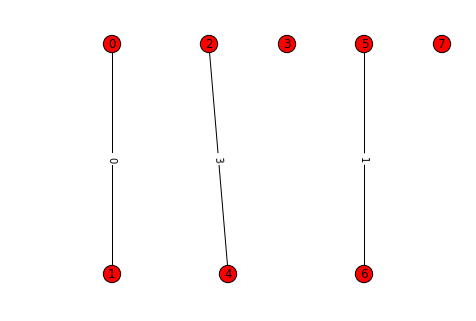

In [31]:
# pos = nx.spring_layout(graph, k=0.5, iterations=1000, scale=100.0)

pos = nx.graphviz_layout(graph, prog='dot') 

nx.draw(graph, pos)

_ = nx.draw_networkx_labels(graph, pos, labels=node_labels)

_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

In [32]:
subgraphs = list(nx.connected_components(graph))

logging.info("No. subgraphs = {}".format(len(subgraphs)))

img_dir = 'images'

html = ''

for n, subgraph in enumerate(subgraphs):
    
    # img = Draw.MolsToGridImage([cores['mol'][x] for x in subgraph], legends=["{} ({})".format(x, cores['n_compounds'][x]) for x in subgraph], molsPerRow=6)
    
    img = Draw.MolsToGridImage(mcs_align([cores['mol'][x] for x in subgraph])['mols'], legends=["{} ({})".format(x, cores['n_compounds'][x]) for x in subgraph], molsPerRow=6)
    
    filename = "{}/img_{:03d}.png".format(img_dir, n)
    
    img.save(filename)
    
    html += '<img src="{}" /> </br>\n'.format(filename)
    
HTML(html)

[2015/Jul/21 12:08:42 INFO    ] No. subgraphs = 5
